In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image, ImageFile
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", Image.DecompressionBombWarning)



# Define dataset path
data_dir = '/kaggle/input/ai-generated-images-vs-real-images/train'


# Set a higher limit if you know your dataset has large images
Image.MAX_IMAGE_PIXELS = None  # Disable the check completely (use with caution)
# or
Image.MAX_IMAGE_PIXELS = 200000000  # Set to a specific safe value (e.g., 200M pixels)


def convert_to_rgb(image):
    """
    Ensures the input image is in RGB mode. Converts images with a palette
    (e.g., PNG or GIF) and transparency to RGBA, then to RGB by blending with a white background.
    """
    if image.mode == 'P':  # Palette-based images
        image = image.convert("RGBA")  # Convert to RGBA
    if image.mode == "RGBA":  # Images with transparency
        # Blend with a white background to remove transparency
        background = Image.new("RGB", image.size, (255, 255, 255))
        image = Image.alpha_composite(background, image).convert("RGB")
    elif image.mode != "RGB":
        image = image.convert("RGB")  # Convert other modes directly to RGB
    return image



def resize_large_image(image, max_size):
    """
    Resize images that exceed a certain size.
    Args:
        image (PIL.Image.Image): Input image.
        max_size (tuple): Maximum allowed dimensions (width, height).
    Returns:
        PIL.Image.Image: Resized image if necessary.
    """
    if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
        image.thumbnail(max_size, Image.Resampling.LANCZOS)  # Use LANCZOS for high-quality downscaling
    return image


train_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),  # Ensure large images are resized
    transforms.Lambda(convert_to_rgb),               # Convert to RGB
    transforms.RandomResizedCrop(224),               # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),          # Randomly flip horizontally with 50% probability
    transforms.RandomVerticalFlip(p=0.2),            # Randomly flip vertically with 20% probability
    transforms.RandomRotation(degrees=15),           # Random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])



val_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  # Convert to RGB
    transforms.Resize((224, 224)),      # Resize images to 224x224
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Minimum file size in bytes for an image to be considered valid
MIN_IMAGE_FILE_SIZE = 3284  # 1 KB (adjust as needed)

# Function to validate images based on size and format
def is_valid_image(file_path):
    """
    Checks if the image file is valid, has enough bytes, and can be opened.
    Args:
        file_path (str): Path to the image file.
    Returns:
        bool: True if valid, False otherwise.
    """
    try:
        # Check file size
        if os.path.getsize(file_path) < MIN_IMAGE_FILE_SIZE:
            return False
        
        # Verify image integrity
        with Image.open(file_path) as img:
            img.verify()  # Verify it's a valid image
        return True
    except (OSError, Image.DecompressionBombError):
        return False

# Custom ImageFolder class that filters invalid images
class ValidImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        # Filter out invalid images
        self.samples = [(path, label) for path, label in self.samples if is_valid_image(path)]
        self.targets = [label for _, label in self.samples]

# Load dataset and validate images
dataset = ValidImageFolder(root=data_dir, transform=train_transform)

In [3]:
from torch.utils.data import Subset
# Separate indices for "fake" and "real" images
fake_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['fake']]
real_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['real']]

# Take 50% from each class
fake_subset_size = int(0.5 * len(fake_indices))
real_subset_size = int(0.5 * len(real_indices))

fake_subset_indices = np.random.choice(fake_indices, fake_subset_size, replace=False)
real_subset_indices = np.random.choice(real_indices, real_subset_size, replace=False)

# Combine the indices for the balanced subset
balanced_subset_indices = np.concatenate((fake_subset_indices, real_subset_indices))

# Create the subset
balanced_subset = Subset(dataset, balanced_subset_indices)

# Print the sizes of the original and subset datasets
print(f"Original Dataset Size: {len(dataset)}")
print(f"Balanced Subset Size: {len(balanced_subset)} (Fake: {fake_subset_size}, Real: {real_subset_size})")


Original Dataset Size: 47998
Balanced Subset Size: 23999 (Fake: 12000, Real: 11999)


In [4]:
# Split the balanced subset into training and validation sets
train_size = int(0.8 * len(balanced_subset))
val_size = len(balanced_subset) - train_size
train_dataset, val_dataset = random_split(balanced_subset, [train_size, val_size])

# Apply validation transforms to validation set
val_dataset.dataset.transform = val_transform

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [5]:
# Print the sizes of the training and validation datasets
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Train Dataset Size: 19199
Validation Dataset Size: 4800


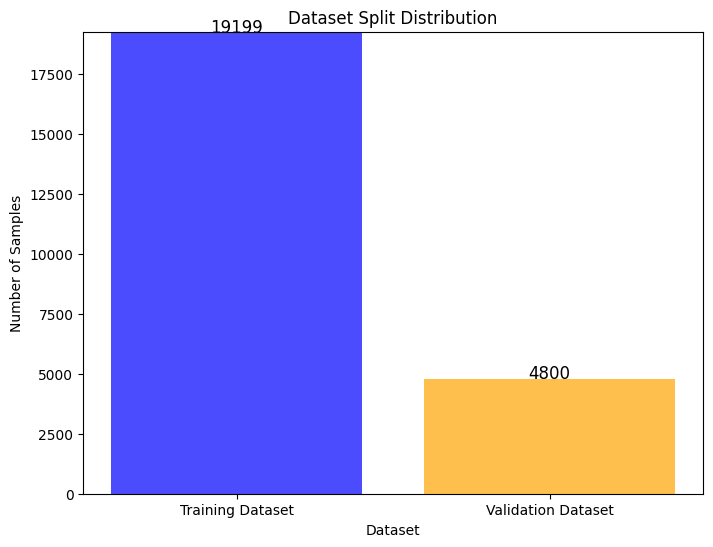

In [6]:
import matplotlib.pyplot as plt

# Calculate dataset sizes
train_size = len(train_dataset)
val_size = len(val_dataset)

# Dataset labels and sizes
labels = ['Training Dataset', 'Validation Dataset']
sizes = [train_size, val_size]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['blue', 'orange'], alpha=0.7)

# Add annotations to the bars
for i, size in enumerate(sizes):
    plt.text(i, size + 5, str(size), ha='center', fontsize=12)

# Add chart details
plt.title('Dataset Split Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Dataset')
plt.ylim(0, max(sizes) + 50)
plt.show()

In [7]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
from torchvision.models import resnet18
import torch.nn as nn

# Load a pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Modify the last fully connected layer with dropout
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # 50% dropout
    nn.Linear(num_ftrs, 2)  # 2 output classes
)

model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


In [9]:
from torch.optim.lr_scheduler import StepLR

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define a scheduler that reduces the learning rate every 3 epochs
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
# Early stopping parameters
patience = 3
trigger_times = 0
best_val_loss = float('inf')


In [11]:
# Training and validation loop
epochs = 11
best_val_acc = 0.0

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [12]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    if val_acc < best_val_acc:
        best_val_acc = val_acc
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model{epoch}.pth')
        trigger_times = 0  # Reset early stopping counter
    else:
        trigger_times += 1
        print(f"Early stopping trigger count: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping...")
            break

    # Step the scheduler
    scheduler.step()

print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Best Validation loss: {best_val_loss:.4f}')


Epoch 1/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.4842 Acc: 0.7763
Val Loss: 0.7411 Acc: 0.6740

Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.39      0.54      2389
        real       0.61      0.95      0.75      2411

    accuracy                           0.67      4800
   macro avg       0.75      0.67      0.65      4800
weighted avg       0.75      0.67      0.65      4800

Epoch 2/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3957 Acc: 0.8245
Val Loss: 0.3954 Acc: 0.8277

Classification Report:
              precision    recall  f1-score   support

        fake       0.81      0.86      0.83      2389
        real       0.85      0.80      0.82      2411

    accuracy                           0.83      4800
   macro avg       0.83      0.83      0.83      4800
weighted avg       0.83      0.83      0.83      4800

Epoch 3/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3527 Acc: 0.8491
Val Loss: 0.4432 Acc: 0.8038

Classification Report:
              precision    recall  f1-score   support

        fake       0.74      0.94      0.83      2389
        real       0.92      0.67      0.77      2411

    accuracy                           0.80      4800
   macro avg       0.83      0.80      0.80      4800
weighted avg       0.83      0.80      0.80      4800

Early stopping trigger count: 1/3
Epoch 4/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3117 Acc: 0.8648
Val Loss: 0.3078 Acc: 0.8663

Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.83      0.86      2389
        real       0.84      0.91      0.87      2411

    accuracy                           0.87      4800
   macro avg       0.87      0.87      0.87      4800
weighted avg       0.87      0.87      0.87      4800

Epoch 5/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2870 Acc: 0.8802
Val Loss: 0.3164 Acc: 0.8665

Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.82      0.86      2389
        real       0.84      0.91      0.87      2411

    accuracy                           0.87      4800
   macro avg       0.87      0.87      0.87      4800
weighted avg       0.87      0.87      0.87      4800

Early stopping trigger count: 1/3
Epoch 6/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2762 Acc: 0.8843
Val Loss: 0.2910 Acc: 0.8815

Classification Report:
              precision    recall  f1-score   support

        fake       0.88      0.88      0.88      2389
        real       0.88      0.89      0.88      2411

    accuracy                           0.88      4800
   macro avg       0.88      0.88      0.88      4800
weighted avg       0.88      0.88      0.88      4800

Epoch 7/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2683 Acc: 0.8884
Val Loss: 0.2893 Acc: 0.8733

Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.85      0.87      2389
        real       0.86      0.89      0.88      2411

    accuracy                           0.87      4800
   macro avg       0.87      0.87      0.87      4800
weighted avg       0.87      0.87      0.87      4800

Epoch 8/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2620 Acc: 0.8889
Val Loss: 0.2829 Acc: 0.8800

Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.87      0.88      2389
        real       0.87      0.89      0.88      2411

    accuracy                           0.88      4800
   macro avg       0.88      0.88      0.88      4800
weighted avg       0.88      0.88      0.88      4800

Epoch 9/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2615 Acc: 0.8899
Val Loss: 0.2828 Acc: 0.8802

Classification Report:
              precision    recall  f1-score   support

        fake       0.88      0.88      0.88      2389
        real       0.88      0.88      0.88      2411

    accuracy                           0.88      4800
   macro avg       0.88      0.88      0.88      4800
weighted avg       0.88      0.88      0.88      4800

Epoch 10/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2592 Acc: 0.8906
Val Loss: 0.2811 Acc: 0.8800

Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.86      0.88      2389
        real       0.87      0.90      0.88      2411

    accuracy                           0.88      4800
   macro avg       0.88      0.88      0.88      4800
weighted avg       0.88      0.88      0.88      4800

Epoch 11/11


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2600 Acc: 0.8928
Val Loss: 0.2833 Acc: 0.8823

Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.88      0.88      2389
        real       0.88      0.89      0.88      2411

    accuracy                           0.88      4800
   macro avg       0.88      0.88      0.88      4800
weighted avg       0.88      0.88      0.88      4800

Early stopping trigger count: 1/3
Best Validation Accuracy: 0.0000
Best Validation loss: 0.2811


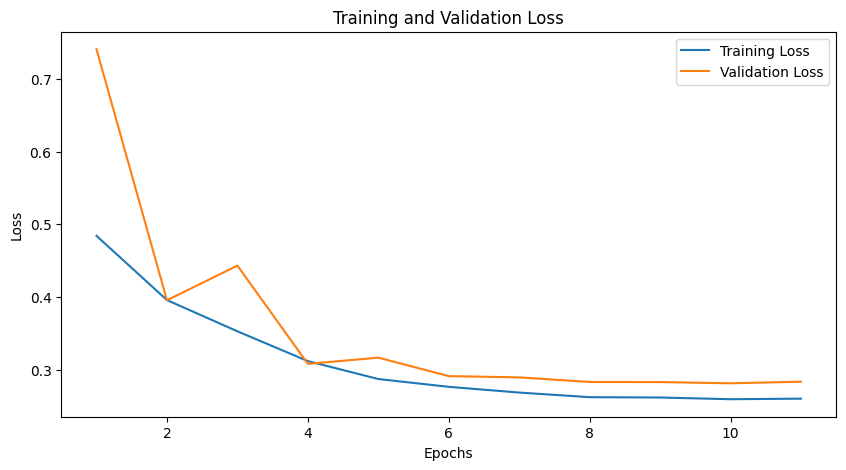

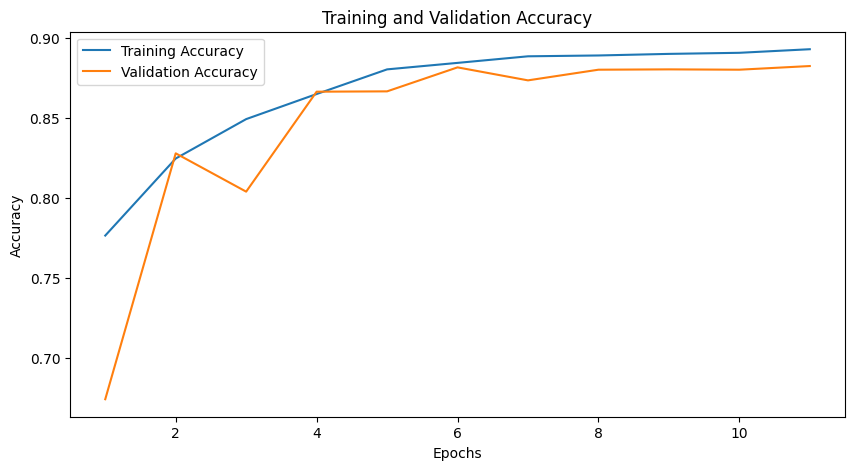

In [13]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
